## Declarations

### Imports

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import math
import string
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython.display import display
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm

import tensorflow_hub as hub
import tensorflow_text as text

tfk = tf.keras
tfkl = tf.keras.layers
kb = tf.keras.backend
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.13.0
Num GPUs Available:  1


### Constants

In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

kaggle1 = "/kaggle/input/transformers-hackathon/"
kaggle2 = "/kaggle/input/transformers-hackathon-features/"

image_dir = "./resized_train"
caption_pred_file = "caption_prediction_train.csv"
concept_det_file = "concept_detection_train.csv"
concept_file = "concepts.csv"

##### Kaggle filepath #####
#image_dir = kaggle1 + image_dir
#caption_pred_file = kaggle2 + caption_pred_file
#concept_det_file = kaggle2 + concept_det_file
#concept_file = kaggle2 + concept_file
###########################

image_size = (128, 128, 3)

batch_size = 10
epochs = 100

## Preprocessing

In [3]:
feature_types = {'image': tf.float16, 'caption': tf.string, 'concepts': tf.bool, 'raw caption': tf.string, 'image path': tf.string}
feature_shapes = {'image': (128, 128, 3), 'caption': (), 'concepts': (8374)}
base_features = ["image", "caption"]

In [4]:
concepts = pd.read_csv(concept_file, sep='\t')
concept_list = concepts.set_index('concept')['concept_name'].to_dict()
# Concept one-hot encoder
concepts_onehot = MultiLabelBinarizer(classes = list(concept_list.keys()))
concepts_onehot.fit([list(concept_list.keys())])

captions = pd.read_csv(caption_pred_file, sep='\t')
captions = captions.set_index('ID')['caption'].to_dict()
captions = {id: "[SOS] " + caption + " [EOS]" for id, caption in captions.items()}

concepts = pd.read_csv(concept_det_file, sep='\t')
concepts = concepts.set_index('ID')['cuis'].to_dict()
concepts = {id: item_concepts.split(";") for id, item_concepts in concepts.items()}

In [5]:
def split(x, test_size=0.2, val_size=0.0, seed=0):
    if val_size + test_size >= 1:
        return None
    x_train, x_test = train_test_split(
        x, test_size=test_size + val_size, random_state=seed
    )
    x_val = None
    if val_size > 0:
        x_test, x_val = train_test_split(
            x_test,
            test_size=val_size / (test_size + val_size),
            random_state=seed,
        )
    return x_train, x_val, x_test

def load_image_from_path(path):
    image = tf.io.read_file(path)
    image = tf.io.decode_jpeg(image, channels=3, dct_method="INTEGER_ACCURATE")

    # may need resizing
    #image = tf.image.resize(image, image_shape[:2])
    image = tf.cast(image, dtype=tf.float16)
    image = image / 255.0
    return image

In [6]:
def custom_standardization(input_string):
    # convert input string to lowercase
    lowercase = tf.strings.lower(input_string)
    # replace special characters with empty string
    # TODO
    #return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")
    return lowercase

In [7]:
result = ""
for i in captions.values():
    result += " " + i
result = custom_standardization(result)
result = bytes.decode(result.numpy())
vocab_size = len(set(result.split()))
print("Vocab size:")
print(vocab_size)

longest = max(captions.values(), key=len)
longest = custom_standardization(longest)
longest = bytes.decode(longest.numpy())
longest = longest.split()
sequence_length = len(longest)
print("Longest sequence:")
print(sequence_length)

concept_size = max([len(c) for _, c in concepts.items()])
print("Max number of concepts:")
print(concept_size)

Vocab size:
35491
Longest sequence:
393
Max number of concepts:
50


In [8]:
def load_features(image_folder, captions_file, concepts_file, concept_encoder, filter_percent=1):
    features = []
    
    # Import CSVs
    csv_caption_dataset = tf.data.experimental.CsvDataset(
        captions_file,
        field_delim='\t',
        record_defaults=[tf.string, tf.string],
        header=True,
        select_cols=[0, 1]
    )
    csv_concept_dataset = tf.data.experimental.CsvDataset(
        concepts_file,
        field_delim='\t',
        record_defaults=[tf.string, tf.string],
        header=True,
        select_cols=[0, 1]
    )
    
    # We make the assumption that CSV files contain the same key values (image names)
    # following the same ordering

    # Extract features from dataset
    print("Extracting features from CSV file(s)")
    for caption_el, concept_el in tqdm(zip(csv_caption_dataset, csv_concept_dataset)):
        filename_cap, caption = caption_el
        filename_con , concepts = concept_el
        
        # Sanity check
        assert filename_cap == filename_con
        
        image_path = image_dir + "/" + filename_cap + ".jpg"
        
        features.append({
            'caption': caption,
            'image path': image_path,
            'concepts': concept_encoder.transform([concepts.numpy().decode("utf-8").split(";")]),
        })
        
    # Filter elements
    if filter_percent != 1:
        n_features = int(len(features) * filter_percent)
        features = random.sample(features, n_features)
        
    return features

def preprocess_features(features, concept_encoder, filter_percent=1):
    print("Preprocessing features")
    
    # Filter elements
    if filter_percent != 1:
        n_features = int(len(features) * filter_percent)
        features = random.sample(features, n_features)
        
    return {
        'image paths': tf.convert_to_tensor([x["image path"] for x in tqdm(features)], dtype=tf.string),
        'captions': tf.convert_to_tensor([x["caption"] for x in tqdm(features)], dtype=tf.string),
        'concepts': tf.convert_to_tensor(np.vstack([concept_encoder.transform(x["concepts"]).flatten() for x in tqdm(features)]), dtype=tf.bool),
        # 'images': tf.convert_to_tensor([load_image(x["image path"]) for x in tqdm(features)], dtype=tf.float16),
    }

In [9]:
# Load dataset features from csv files, split them and preprocess them
features = load_features(image_dir, caption_pred_file, concept_det_file, concepts_onehot, filter_percent=1)
feat_train, feat_val, feat_test = split(features, test_size=0.2, val_size=0.0, seed=seed)

#feat_train = preprocess_features(features, concepts_onehot, filter_percent=0.01) if feat_train else None
#feat_val = preprocess_features(features, concepts_onehot, filter_percent=0.01) if feat_val else None
#feat_test = preprocess_features(features, concepts_onehot, filter_percent=0.01) if feat_test else None

Extracting features from CSV file(s)


0it [00:00, ?it/s]

83275it [00:44, 1881.18it/s]


In [10]:
def create_dataset(
        features, 
        input_features_types,
        feature_shapes,
        x_features, y_features=None, 
        x_dict=True, y_dict=True,
        load_images=True, 
        shuffle_buffer_size=1024, 
        batch_size=10, 
        cached=False
):
    # Generate dataset following initial input feature types
    dataset = tf.data.Dataset.from_generator(
        lambda: features, { x: input_features_types[x] for x in input_features_types }
    )
    
    # Preprocessing internal functions
    def setshape(e):
        for (k, v) in feature_shapes.items():
            if k in e:
                e[k].set_shape(v)
        return e
    def add_images(e):
        # Maybe parametrize
        img_from = "image path"
        img_to = "image"
        new_features = list(input_features_types.keys()) + [img_to]
        return {f:e[f] if f != img_to else load_image_from_path(e[img_from]) for f in new_features}
    def split_xy(e):
        e_x = {xf:e[xf] for xf in x_features} if x_dict else tf.squeeze([e[xf] for xf in x_features])
        if y_features:
            e_y = {yf:e[yf] for yf in y_features} if y_dict else tf.squeeze([e[yf] for yf in y_features])
            return (e_x, e_y)
        return e_x
    
    # Preprocess
    if load_images:
        dataset = dataset.map(add_images)
    dataset = dataset.map(setshape)
    dataset = dataset.map(split_xy)

    # Compile dataset
    if cached:
        dataset = dataset.cache()
    dataset = dataset.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

def visualize_first_of_dataset_batch(dataset_batch, nums=5):
    for c in range(0, nums):
        i = tf.cast(dataset_batch["image"][c], dtype=tf.float32)
        t = dataset_batch["raw caption"][c]
        plt.figure(figsize=(50, 100))
        plt.subplot(nums, 1, c + 1)
        plt.imshow(i)
        plt.title(f"{t}", fontsize=100)
        plt.xticks([])
        plt.yticks([])
def visualize_first_of_dataset_batch(dataset_batch, nums=5):
    for c in range(0, nums):
        i = tf.cast(dataset_batch["image"][c], dtype=tf.float32)
        t = dataset_batch["raw caption"][c]
        plt.figure(figsize=(50, 100))
        plt.subplot(nums, 1, c + 1)
        plt.imshow(i)
        plt.title(f"{t}", fontsize=100)
        plt.xticks([])
        plt.yticks([])

In [11]:
in_feat_typ = {'caption': tf.string, 'concepts': tf.bool, 'image path': tf.string}
x_features = ['caption', 'image']
x_features_iep = ['image']
y_features_iep = ['concepts']

train_ds_size = len(feat_train) if feat_train else 0
val_ds_size = len(feat_val) if feat_val else 0
test_ds_size = len(feat_test) if feat_test else 0

train_dataset = create_dataset(feat_train, input_features_types=in_feat_typ, feature_shapes=feature_shapes, x_features=x_features) if feat_train else None
val_dataset = create_dataset(feat_val, input_features_types=in_feat_typ, feature_shapes=feature_shapes, x_features=x_features) if feat_val else None
test_dataset = create_dataset(feat_test, input_features_types=in_feat_typ, feature_shapes=feature_shapes, x_features=x_features) if feat_test else None

train_dataset_iep = create_dataset(feat_train, input_features_types=in_feat_typ, feature_shapes=feature_shapes, x_features=x_features_iep, y_features=y_features_iep, x_dict=False, y_dict=False, batch_size=batch_size, cached=True) if feat_train else None
val_dataset_iep = create_dataset(feat_val, input_features_types=in_feat_typ, feature_shapes=feature_shapes, x_features=x_features_iep, y_features=y_features_iep, x_dict=False, y_dict=False, batch_size=batch_size, cached=True) if feat_val else None
test_dataset_iep = create_dataset(feat_test, input_features_types=in_feat_typ, feature_shapes=feature_shapes, x_features=x_features_iep, y_features=y_features_iep, x_dict=False, y_dict=False, batch_size=batch_size, cached=True) if feat_test else None

## Download Models

In [12]:
text_preprocess = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2",
        name="text_preprocessing",
    )

text_transformer = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1",
        trainable=True,
        name="bert",
    )

img_preprocess = tfk.applications.convnext.preprocess_input

img_supernet = tfk.applications.ConvNeXtTiny(weights='imagenet', include_top=False)
supernet_name = img_supernet.name

## Pre-pre-training

In [13]:
def image_encoder_pretrainer(preprocessing, supernet, n_concepts, input_shape=(128,128,3), learning_rate=1e-5):
    
    input_layer = tfkl.Input(shape=input_shape, name='image')

    x = preprocessing(input_layer)
    x = supernet(x)
    
    x = tfkl.GlobalMaxPooling2D(name='GAP')(x)
    x = tfkl.Dense(256, activation='relu')(x)
    x = tfkl.Dense(128, activation='relu')(x)
    x = tfkl.Dense(n_concepts, activation="sigmoid", name='output')(x)

    image_encoder_pretrainer = tfk.Model(inputs=input_layer, outputs=x, name="image_encoder_pretrainer")
    image_encoder_pretrainer.compile(
        loss="binary_crossentropy", optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
    )
    
    return image_encoder_pretrainer

In [14]:
iep = image_encoder_pretrainer(img_preprocess, img_supernet, len(concept_list.keys()))

In [15]:
# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss", patience = 5, restore_best_weights = True
)

history = iep.fit(
    train_dataset_iep,
    epochs = 5,
    validation_data = test_dataset_iep,
    callbacks = [early_stopping],
)

Epoch 1/5


6662/6662 [==============================] - 485s 69ms/step - loss: 0.0238 - val_loss: 0.0035
Epoch 2/5
6662/6662 [==============================] - 499s 75ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 3/5
6662/6662 [==============================] - 500s 75ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 4/5
6662/6662 [==============================] - 497s 75ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 5/5
6662/6662 [==============================] - 498s 75ms/step - loss: 0.0031 - val_loss: 0.0032


In [16]:
img_supernet = iep.layers[1]

## Network

### Network blocks

In [13]:
def image_encoder(input_shape, embed_dim, seed=42, supernet=None, preprocessing=None):
    
    tf.random.set_seed(seed)

    input_layer = tfkl.Input(shape=input_shape, name='img_input_layer')

    x = preprocessing(input_layer)
    x = supernet(x)

    x = tfkl.GlobalAveragePooling2D(name='GAP')(x)

    # Projection
    embeddings = tfkl.Dense(embed_dim)(x)
    x = tf.nn.selu(embeddings)
    x = tfkl.Dense(embed_dim, name='img_embedding_output_layer')(x)
    x = tfkl.Dropout(0.1)(x)
    x = tfkl.Add()([x, embeddings])
    x = tfkl.LayerNormalization()(x)

    # Connect input and output through the Model class
    cnn_encoder = tfk.Model(inputs=input_layer, outputs=x, name='image_encoder')

    # Return the encoder
    return cnn_encoder

In [14]:
def text_encoder(embed_dim, preprocess, transformer, trainable=True):

    transformer.trainable = trainable
    
    input_layer = tfkl.Input(shape=(), dtype=tf.string, name="text_input")
    x = preprocess(input_layer)
    x = transformer(x)["pooled_output"]
    

    # Projection
    embeddings = tfkl.Dense(embed_dim)(x)
    x = tf.nn.selu(embeddings)
    x = tfkl.Dense(embed_dim, name='img_embedding_output_layer')(x)
    x = tfkl.Dropout(0.1)(x)
    x = tfkl.Add()([x, embeddings])
    x = tfkl.LayerNormalization()(x)

    text_encoder = tfk.Model(inputs=input_layer, outputs=x, name="text_encoder")
    
    return text_encoder

In [15]:
class CLIP(tfk.Model):
    def __init__(self, image_encoder, text_encoder, temp=0.07, **kwargs):
        super().__init__(**kwargs)
        self.image_encoder = image_encoder
        self.text_encoder = text_encoder
        self.temp = temp
        self.loss_tracker = tfk.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, features, training=False):
        image_emb = self.image_encoder(features["image"], training=training)
        text_emb = self.text_encoder(features["caption"], training=training)
        return image_emb, text_emb

    def CLIP_loss(self, image_emb, text_emb):
        norm_image_emb = tf.math.l2_normalize(image_emb, axis=1)
        norm_text_emb = tf.math.l2_normalize(text_emb, axis=1)

        logits = tf.linalg.matmul(norm_image_emb, norm_text_emb, transpose_b=True) * tf.math.exp(self.temp)

        n = tf.shape(logits)[0]
        labels = tf.range(n)

        loss_img = tfk.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
        loss_txt = tfk.losses.sparse_categorical_crossentropy(labels, kb.transpose(logits), from_logits=True)

        return (loss_img + loss_txt) / tf.constant(2.0)

    def train_step(self, features):
        with tf.GradientTape() as tape:
            image_embeddings, caption_embeddings = self(features, training=True)
            loss = self.CLIP_loss(caption_embeddings, image_embeddings)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, features):
        image_embeddings, caption_embeddings = self(features, training=False)
        loss = self.CLIP_loss(caption_embeddings, image_embeddings)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


### Building network

In [16]:
def build_clip(img_input_shape=(128,128,3),
               txt_input_shape=(393, ), 
               embed_dim=128, 
               temp=0.07,
               learning_rate=2e-5,
               img_supernet=None,
               img_preprocess=None,
               text_transformer=None,
               text_preprocess=None):

    
    text_encoder_model = text_encoder(embed_dim, text_preprocess, text_transformer)
    image_encoder_model = image_encoder(img_input_shape, embed_dim, supernet=img_supernet, preprocessing=img_preprocess)

    clip = CLIP(image_encoder_model, text_encoder_model, temp)
    clip.compile(optimizer = tf.optimizers.Adam(learning_rate=learning_rate))

    return image_encoder_model, text_encoder_model, clip

In [17]:
clip_image_encoder, clip_text_encoder, clip = build_clip(
    img_supernet=img_supernet,
    img_preprocess=img_preprocess,
    text_transformer=text_transformer,
    text_preprocess=text_preprocess,
)

## Training

### Phase 1
Traning all the parameters

In [23]:
# Create a learning rate scheduler callback.
reduce_lr = tfk.callbacks.ReduceLROnPlateau(
    monitor = "val_loss", factor = 0.2, patience = 3
)

# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss", patience = 5, restore_best_weights = True
)

history_phase1 = clip.fit(
    train_dataset,
    epochs = epochs,
    validation_data = test_dataset,
    callbacks = [reduce_lr, early_stopping],
)

Epoch 1/100


6662/6662 [==============================] - 491s 70ms/step - loss: 1.8025 - val_loss: 1.7341 - lr: 2.0000e-05
Epoch 2/100
6662/6662 [==============================] - 439s 66ms/step - loss: 1.6895 - val_loss: 1.6903 - lr: 2.0000e-05
Epoch 3/100
6662/6662 [==============================] - 452s 68ms/step - loss: 1.6453 - val_loss: 1.6456 - lr: 2.0000e-05
Epoch 4/100
6662/6662 [==============================] - 442s 66ms/step - loss: 1.6173 - val_loss: 1.6390 - lr: 2.0000e-05
Epoch 5/100
6662/6662 [==============================] - 425s 64ms/step - loss: 1.5953 - val_loss: 1.6396 - lr: 2.0000e-05
Epoch 6/100
6662/6662 [==============================] - 526s 79ms/step - loss: 1.5787 - val_loss: 1.6286 - lr: 2.0000e-05
Epoch 7/100
6662/6662 [==============================] - 504s 76ms/step - loss: 1.5661 - val_loss: 1.6323 - lr: 2.0000e-05
Epoch 8/100
6662/6662 [==============================] - 447s 67ms/step - loss: 1.5562 - val_loss: 1.6225 - lr: 2.0000e-05
Epoch 9/100
6662/6662 [=====

### Phase 2
Training the projection only

In [26]:
img_supernet.trainable = False
text_transformer.trainable = False

In [27]:
clip.compile(optimizer = tf.optimizers.Adam(learning_rate=5e-5))

In [28]:
history_phase2 = clip.fit(
    train_dataset,
    epochs = epochs,
    validation_data = test_dataset,
    callbacks = [early_stopping, reduce_lr],
)

Epoch 1/100


6662/6662 [==============================] - 186s 27ms/step - loss: 1.5070 - val_loss: 1.6106 - lr: 5.0000e-05
Epoch 2/100
6662/6662 [==============================] - 177s 27ms/step - loss: 1.5050 - val_loss: 1.6101 - lr: 5.0000e-05
Epoch 3/100
6662/6662 [==============================] - 176s 26ms/step - loss: 1.5040 - val_loss: 1.6081 - lr: 5.0000e-05
Epoch 4/100
6662/6662 [==============================] - 177s 26ms/step - loss: 1.5045 - val_loss: 1.6083 - lr: 5.0000e-05
Epoch 5/100
6662/6662 [==============================] - 177s 27ms/step - loss: 1.5041 - val_loss: 1.6105 - lr: 5.0000e-05
Epoch 6/100
6662/6662 [==============================] - 177s 26ms/step - loss: 1.5048 - val_loss: 1.6102 - lr: 5.0000e-05
Epoch 7/100
6662/6662 [==============================] - 174s 26ms/step - loss: 1.5041 - val_loss: 1.6103 - lr: 1.0000e-05
Epoch 8/100
6662/6662 [==============================] - 174s 26ms/step - loss: 1.5043 - val_loss: 1.6067 - lr: 1.0000e-05
Epoch 9/100
6662/6662 [=====

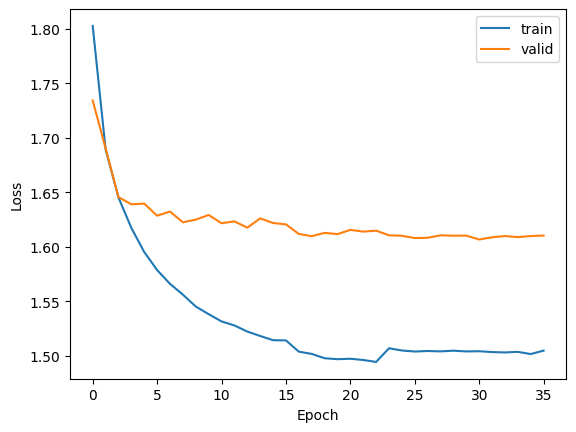

In [29]:
plt.plot(history_phase1.history["loss"]+history_phase2.history["loss"])
plt.plot(history_phase1.history["val_loss"]+history_phase2.history["val_loss"])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "valid"], loc="upper right")
plt.show()

## Task performance

In [19]:
def generate_image_embeddings(
    image_encoder,                 # Image encoder of clip model
    dataset_eval,                  # Dataset to generate embeddings (WARNING: the dataset must not be shuffling or have a shuffle buffer size of 1)
    dataset_pred_map=lambda *x: x, # Lambda mapping function for prediction
    dataset_ref_map=lambda *x: x,  # Lambda mapping function for reference
):
    print("Generating image embeddings")
    image_embeddings = image_encoder.predict(
        dataset_eval.map(dataset_pred_map),
        verbose=1,
    )
    dataset_reference = [x for x in train_dataset_eval.map(dataset_ref_map).unbatch()]
    return dataset_reference, image_embeddings

def find_t2i_matches(
    queries,                # Queries to search
    text_encoder,           # Text encoder of clip model
    image_embeddings,       # Generated image embeddings
    dataset_reference=None, # Reference for retreived dataset elements following indices
    k=5,                    # Number of elements for top-k
    normalize=True,         # Embedding normalization
):
    print("Computing Text-to-Image matches")
    # Generate query dataset and get their embeddings
    queries_ds = tf.data.Dataset.from_tensor_slices(queries).batch(batch_size)
    query_embedding = text_encoder.predict(queries_ds)
    # Normalize the query and the image embeddings
    if normalize:
        image_embeddings = tf.math.l2_normalize(image_embeddings, axis=1)
        query_embedding = tf.math.l2_normalize(query_embedding, axis=1)
    # Compute the dot product between the query and the image embeddings
    dot_similarity = tf.matmul(query_embedding, image_embeddings, transpose_b=True)
    # Retrieve top k indices
    results = tf.math.top_k(dot_similarity, k).indices.numpy()
    return results

def index_to_reference(results, dataset_reference):
    return [[dataset_reference[match] for match in result] for result in results]

def visualize_t2i_results(matches):
    # Assuming matches are in the form of tuples: (image_path, caption)
    print("Top matches for query: \"" + query + "\"")
    plt.figure(figsize=(18, 18))
    for i in range(len(matches)):
        path = matches[i][0].numpy().decode('UTF-8')
        caption = matches[i][1].numpy().decode('UTF-8')
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(mpimg.imread(path))
        plt.axis("off")
        print(f"{i}) {caption}")



In [20]:
query = "active pheochromocytoma"
# WARNING: currently using train_dataset_eval
dataset_reference, image_embeddings = generate_image_embeddings(
    clip_image_encoder,
    train_dataset_eval,
    dataset_pred_map=lambda x, y: x['image'],
    dataset_ref_map=lambda x, y: (x['image path'], y['caption'])
)
results = find_t2i_matches([query], clip_text_encoder, image_embeddings, dataset_reference, k=5, normalize=True)
for matches in results:
    visualize_t2i_results(matches)

NameError: name 'train_dataset_eval' is not defined

In [ ]:
# TODO: assumption that the whole dataset is used as a query for most metrics: **
def compute_relevant_at_k(results, dataset_reference, k=None, reference_preprocess=lambda x: x, relevance=lambda m, o: m == o):
    if not k:
        k = len(results[0])
    return [ 
        np.count_nonzero([relevance(match, original) for match in list(map(reference_preprocess, matches))[0:k]])
        for matches, original in zip(results, map(reference_preprocess, dataset_reference)) # **
    ]

#def compute_total_relevance(queries, dataset_reference, reference_preprocess=lambda x: x, relevance=lambda m, o: m == o):
#    return [ 
#        np.count_nonzero([relevance(query, element) for element in map(reference_preprocess, dataset_reference)])
#        for query in tqdm(queries)
#    ]

def compute_top_k_accuracy(results, dataset_reference, relevant_at_k=None, k=None, reference_preprocess=lambda x: x, relevance=lambda m, o: m == o):
    if not relevant_at_k:
        relevant_at_k = compute_relevant_at_k(results, dataset_reference, k, reference_preprocess=reference_preprocess, relevance=relevance)
    hits = np.count_nonzero(relevant_at_k)
    return hits / len(dataset_reference)

def compute_map_k(results, dataset_reference, relevant_at_k=None, k=None, reference_preprocess=lambda x: x, relevance=lambda m, o: m == o):
    if not k:
        k = len(results[0])
    if not relevant_at_k:
        relevant_at_k = compute_relevant_at_k(results, dataset_reference, k, reference_preprocess=reference_preprocess, relevance=relevance)
    precision_at_k = [r/k for r in relevant_at_k]
    return np.sum(precision_at_k) / len(dataset_reference)

def compute_mar_k(results, dataset_reference, relevant_at_k=None, total_relevant=None, k=None, reference_preprocess=lambda x: x, relevance=lambda m, o: m == o):
    if not k:
        k = len(results[0])
    if not relevant_at_k:
        relevant_at_k = compute_relevant_at_k(results, dataset_reference, k, reference_preprocess=reference_preprocess, relevance=relevance)
    if not total_relevant_at_k:
        total_relevant = compute_total_relevance(results, dataset_reference, reference_preprocess=reference_preprocess, relevance=relevance)
    recall_at_k = [rk/tr for rk, tr in zip(relevant_at_k, total_relevant)] # **
    return np.sum(recall_at_k) / len(dataset_reference)

In [ ]:
k = 5
concept_overlap_threshold = 2
reference_preprocess_cap = lambda x: x[0].numpy().decode('UTF-8')                                    # Function to preprocess data when we want to evaluate captions
reference_preprocess_con = lambda x: x[1]                                                            # Function to preprocess data when we want to evaluate concepts
concept_relevance = lambda m, o: np.count_nonzero(np.logical_and(m, o)) >= concept_overlap_threshold # Function to compute if a match is relevant given concept arrays 

print("### Scoring training data ###")
train_dataset_reference, train_image_embeddings = generate_image_embeddings(
    clip_image_encoder,
    train_dataset_eval,
    dataset_pred_map=lambda x, y: x['image'],
    dataset_ref_map=lambda x, y: (y['caption'], y['concepts'])
)
train_queries = [e[0] for e in train_dataset_reference]
# Compute relevance for all the queries in the dataset using only caption equality as a metric
#train_tot_relevant = compute_total_relevance(train_queries, train_dataset_reference, reference_preprocess=reference_preprocess_cap)
# Compute matching results and extrapolate relevant matches based on different criterions
train_raw_results = find_t2i_matches(train_queries, clip_text_encoder, train_image_embeddings, k=5, normalize=True)
train_results = index_to_reference(train_raw_results, train_dataset_reference)
train_relevant_cap = compute_relevant_at_k(train_results, train_dataset_reference, reference_preprocess=reference_preprocess_cap)
train_relevant_con = compute_relevant_at_k(train_results, train_dataset_reference, reference_preprocess=reference_preprocess_con, relevance=concept_relevance)

print("\n### Scoring test data ###")
test_dataset_reference, test_image_embeddings = generate_image_embeddings(
    clip_image_encoder,
    test_dataset_eval,
    dataset_pred_map=lambda x, y: x['image'],
    dataset_ref_map=lambda x, y: (y['caption'], y['concepts'])
)
test_queries = [e[0] for e in test_dataset_reference]
# Compute relevance for all the queries in the dataset using only caption equality as a metric
#test_tot_relevant = compute_total_relevance(test_queries, test_dataset_reference, reference_preprocess=reference_preprocess_cap)
# Compute matching results and extrapolate relevant matches based on different criterions
test_raw_results = find_t2i_matches(test_queries, clip_text_encoder, test_image_embeddings, k=5, normalize=True)
test_results = index_to_reference(test_raw_results, test_dataset_reference)
test_relevant_cap = compute_relevant_at_k(test_results, test_dataset_reference, reference_preprocess=reference_preprocess_cap)
test_relevant_con = compute_relevant_at_k(test_results, test_dataset_reference, reference_preprocess=reference_preprocess_con, relevance=concept_relevance)

In [ ]:
print("### Training data ###")
train_accuracy_cap = compute_top_k_accuracy(train_results, train_dataset_reference, relevant_at_k=train_relevant_cap)
train_accuracy_con = compute_top_k_accuracy(train_results, train_dataset_reference, relevant_at_k=train_relevant_con)
print(f"Accuracy for caption equality: {round(train_accuracy_cap * 100, 3)}%")
print(f"Accuracy for concept overlap: {round(train_accuracy_con * 100, 3)}%")
train_map_cap = compute_map_k(train_results, train_dataset_reference, relevant_at_k=train_relevant_cap)
train_map_con = compute_map_k(train_results, train_dataset_reference, relevant_at_k=train_relevant_con)
print(f"Mean Average Precision for caption equality: {round(train_map_cap * 100, 3)}%")
print(f"Mean Average Precision for concept overlap: {round(train_map_con * 100, 3)}%")

print("\n### Test data ###")
test_accuracy_cap = compute_top_k_accuracy(test_results, test_dataset_reference, relevant_at_k=test_relevant_cap)
test_accuracy_con = compute_top_k_accuracy(test_results, test_dataset_reference, relevant_at_k=test_relevant_con)
print(f"Accuracy for caption equality: {round(test_accuracy_cap * 100, 3)}%")
print(f"Accuracy for concept overlap: {round(test_accuracy_con * 100, 3)}%")
test_map_cap = compute_map_k(test_results, test_dataset_reference, relevant_at_k=test_relevant_cap)
test_map_con = compute_map_k(test_results, test_dataset_reference, relevant_at_k=test_relevant_con)
print(f"Mean Average Precision for caption equality: {round(test_map_cap * 100, 3)}%")
print(f"Mean Average Precision for concept overlap: {round(test_map_con * 100, 3)}%")